# IEEE-CIS 欺诈检测-数据分析
* `identity`身份信息表 
    * 记录每个交易相关的身份信息 40
    * DeviceType
    * DeviceInfo
    * id_1 - id_38
* `transaction`交易信息表
    * 每笔交易的信息 392
    * TransactionID: ID, isFraud: target
    * TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
    * TransactionAMT: transaction payment amount in USD
    * ProductCD: product code, the product for each transaction
    * card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
    * addr: address
    * dist: distance
    * P_ and (R__) emaildomain: purchaser and recipient email domain
    * C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
    * D1-D15: timedelta, such as days between previous transaction, etc.
    * M1-M9: match, such as names on card and address, etc.
    * Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- train
    - identity 144233, transaction 590540
- test
    - identity 141907, transaction 506691

## 只读取数据前10000行进行数据分析

In [1]:
import pandas as pd
INPUT_PATH = '../input/ieee-fraud-detection/'
nrows = 10000
train_identity_df = pd.read_csv(INPUT_PATH+'train_identity.csv', nrows=nrows)
train_transaction_df = pd.read_csv(INPUT_PATH+'train_transaction.csv', nrows=nrows)
test_identity_df = pd.read_csv(INPUT_PATH+'test_identity.csv', nrows=nrows)
test_transaction_df = pd.read_csv(INPUT_PATH+'test_transaction.csv', nrows=nrows)

# 将两个表按照ID拼接起来
train_df = pd.merge(train_transaction_df, train_identity_df, 
                    on='TransactionID', how='left') # how='left‘保留左边表的每一行
test_df = pd.merge(test_transaction_df, test_identity_df, 
                   on='TransactionID', how='left')

In [2]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### 缺失值相关性分析 -> 数据中很多特征是成组出现的，处理时可以按组处理
- 一个变量的存在或不存在如何强烈影响的另一个的存在
- 两个变量相关性为1，一个变量缺失另一个也肯定缺失
- 两个变量相关性为-1，一个变量缺失，另一个肯定存在

<AxesSubplot:>

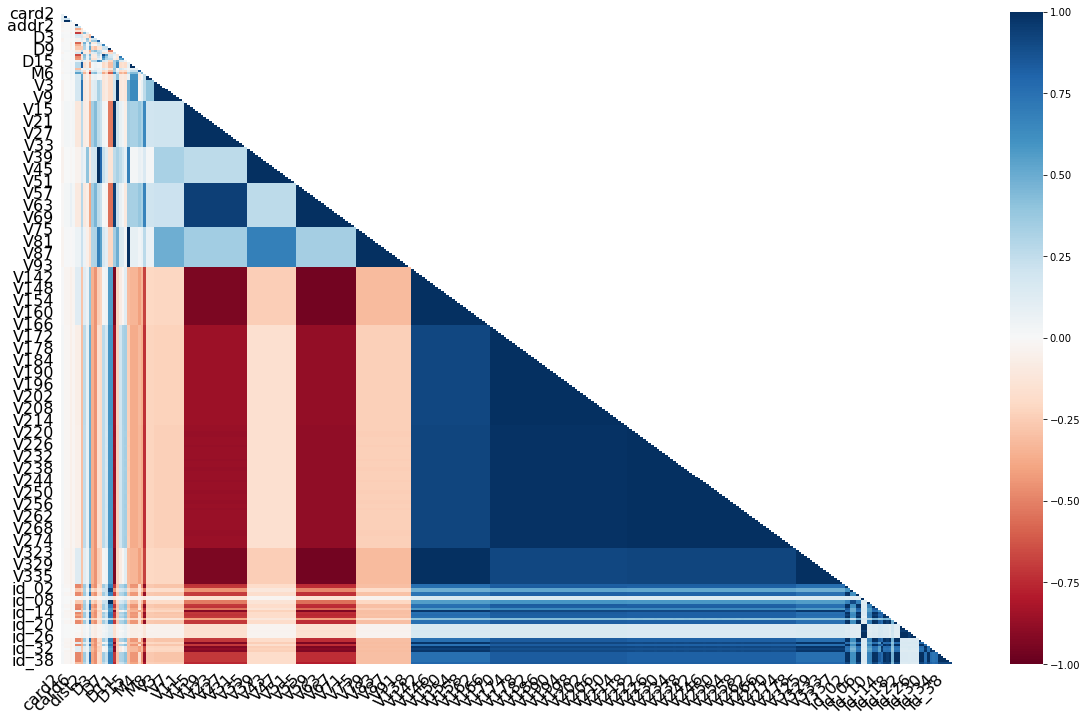

In [3]:
import missingno as msno
msno.heatmap(train_df.iloc[:, 2:], labels=False)

### 特征和标签的相关性分析
- pearson皮尔逊相关性系数，两个变量间协方差和标准差的商
- 一般大于0.2可以认为两个特征是相关的

<AxesSubplot:>

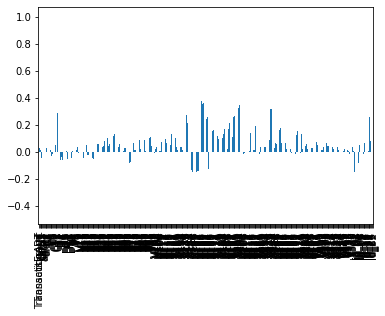

In [4]:
train_df.iloc[:,1:].corr().iloc[0].dropna().plot(kind='bar')

### 小提琴图可以看出某个特征在两类样本上的分布的不同，说明这个特征和类别是相关的

<AxesSubplot:xlabel='isFraud', ylabel='card1'>

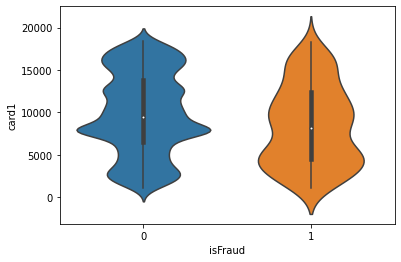

In [5]:
import seaborn as sns
sns.violinplot(data=train_df, y='card1', x='isFraud')

### `TransactionDT`交易时间分析
- 训练数据和测试数据的时间不交叉
- 可能会导致模型预测结果的偏移

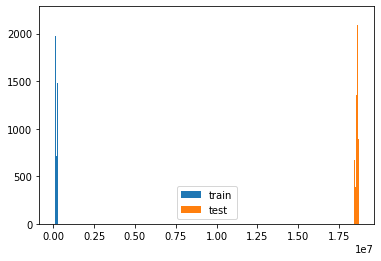

In [6]:
import matplotlib.pyplot as plt
plt.hist(train_df['TransactionDT'])
plt.hist(test_df['TransactionDT'])
plt.legend(['train', 'test'])

### `ProductCD`商品code和标签的相关性分析 - 不同商品类别的欺诈概率差异较大

<AxesSubplot:xlabel='ProductCD'>

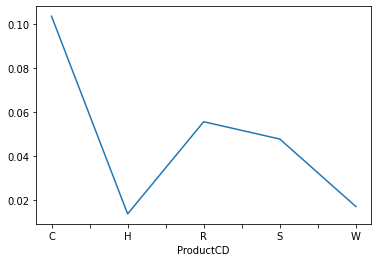

In [7]:
train_df.groupby(['ProductCD'])['isFraud'].mean().plot()

In [8]:
train_df['ProductCD'].value_counts()

W    7709
C     906
H     871
R     305
S     209
Name: ProductCD, dtype: int64

### `P_emaildomain`邮箱地址和类别的相关性分析

<AxesSubplot:>

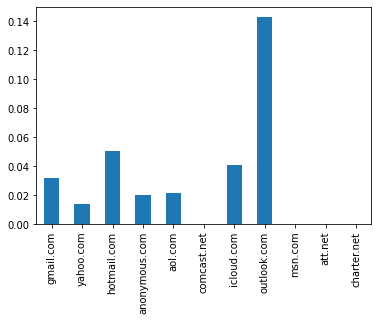

In [9]:
emaildomain_counts = train_df['P_emaildomain'].value_counts()
train_df.groupby(['P_emaildomain'])['isFraud'].mean().loc[emaildomain_counts[emaildomain_counts > 50].index].plot(kind='bar')

In [11]:
emaildomain_counts[emaildomain_counts > 50].index

Index(['gmail.com', 'yahoo.com', 'hotmail.com', 'anonymous.com', 'aol.com',
       'comcast.net', 'icloud.com', 'outlook.com', 'msn.com', 'att.net',
       'charter.net'],
      dtype='object')

In [12]:
print(train_df.columns.values)

['TransactionID' 'isFraud' 'TransactionDT' 'TransactionAmt' 'ProductCD'
 'card1' 'card2' 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1'
 'dist2' 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6'
 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5'
 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3'
 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8'
 'V9' 'V10' 'V11' 'V12' 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20'
 'V21' 'V22' 'V23' 'V24' 'V25' 'V26' 'V27' 'V28' 'V29' 'V30' 'V31' 'V32'
 'V33' 'V34' 'V35' 'V36' 'V37' 'V38' 'V39' 'V40' 'V41' 'V42' 'V43' 'V44'
 'V45' 'V46' 'V47' 'V48' 'V49' 'V50' 'V51' 'V52' 'V53' 'V54' 'V55' 'V56'
 'V57' 'V58' 'V59' 'V60' 'V61' 'V62' 'V63' 'V64' 'V65' 'V66' 'V67' 'V68'
 'V69' 'V70' 'V71' 'V72' 'V73' 'V74' 'V75' 'V76' 'V77' 'V78' 'V79' 'V80'
 'V81' 'V82' 'V83' 'V84' 'V85' 'V86' 'V87' 'V88' 'V89' 'V90' 'V91' 'V92'
 'V93' 'V94' 'V95' 'V96' 'V97' 'V98' 'V99' 'V100' 'V101' 'V1